# Problem

    In energy production, the power grid is a a large directed graph of energy consumers and producers. At times you need to cut at certain nodes and trim demand because you cannot supply enough of a load.

    In DailyProgrammeropolis, all buildings are connected to the grid and all consume power to varying degrees. Some generate power because they have installed on-site generation and sell the excess to the grid, some do not.

    The scenario you're facing is this: due to a fault with the bulk power generation facility not local to DailyProgrammerololis, you must trim the power grid. You have connectivity data, and power consumption and production data. Your goal with this challenge is to maximize the number of powered nodes with the generated energy you have. Note that when you cut off a node, you run the risk the downstream ones will loose power, too, if they are no longer connected. This is how you'll shed demand, by selectively cutting the graph. You can make as many cuts as you want (there is no restriction on this).
   
# Input

    You'll be given an extensive set of data for this challenge. The first set of data looks like this: you'll be given a single integer on one line telling you how many nodes to read. Then you'll be given those nodes, one per line, with the node ID, the amount of power it consumes in kWH, then how much the node generates in kWH. Not all nodes produce electricity, but some do (e.g. a wind farm, solar cells, etc), and there is obviously one that generates the most - that's your main power plant.
    
    The next set of data is the edge data. The first line is how many edges to read, then the next N lines have data showing how the nodes are connected (e.g. power flows from node a to b).
    
# Output

    Your program should emit a list of edges to sever as a list of (i,j) two tuples. Multiple answers are possible. You may wind up with a number of small islands as opposed to one powered network.

# Pseudo

    For ease of use i call the power of a node = production - consumption.

    This graph can be approached as a directed gaph.
    For each edge in microgrid_edges, create 2 directed edges.
    Each has weight equal to tail of directed edge.
    
    There are only 7 of nodes in the graph that have a postive power, 
    [100, 90, 61, 84, 34, 82, 36]
    Note that these form 4 clusters of nodes that are directly connected. 
    (100,90,36),(34,61),(84),(82)
       
    A greedy approximation would be to grow these clusters by looking for the smallest power consuming leaves,
    reducing surplus per cluster gradually, untill no futher nodes can be added.
    
    If during this growth, the clusters connect, merge them.
    This will allow using the leftover power.
    
    This will results in a small number of disconnected clusters which satisfy the power constraint,
    and which contain many nodes of the graph.
    
    We now have to verify if this solution is optimal or not.
    

In [1]:
import heapq
from collections import deque

# Prepare data

In [2]:
with open('nodes.txt') as file:
    space = [line for line in file.read().split('\n')]

size_n = int(space[0])
l_nodes = [[int(float(x)*10**3) for x in line.split(' ')] for line in space[1:]]
d_nodes = {x//10**3:(z-y) for x,y,z in l_nodes}

with open('microgrid_edges.txt') as file:
    space = [line for line in file.read().split('\n')]
    
l_edges = [[int(x) for x in line.split(' ')] for line in space[1:-1]]
d_edges = {x:[] for x in range(size_n)}

for x,y in l_edges:
    d_edges[x].append(y)
    d_edges[y].append(x)   
    
hubs = sorted([(x,y) for x,y in d_nodes.items() if y > 0],key = lambda x:x[1], reverse = True)

clusters = {node:[1,power,set([node]),[]] for node,power in hubs}
unpowered_nodes = set(x for x in range(101) if not x in clusters)

for x,y in clusters.items():
    for edge in d_edges[x]:
        heapq.heappush(y[3],(-d_nodes[edge],edge))  

# Grow and merge clusters

    A greedy approximation would be to grow these clusters by looking for the smallest power consuming leaves,
    reducing surplus per cluster gradually, untill no futher nodes can be added.

    If during this growth, the clusters connect, merge them.
    This will allow using the leftover power.

In [3]:
while any(x[0] for x in clusters.values() if x[0]):
    
    for current,c_cluster in clusters.items():
        
        # only active clusters
        if c_cluster[0]:
            
            w,n = heapq.heappop(c_cluster[3])
    
            # add node to cluster if possible
            if n in unpowered_nodes:
                if w <= c_cluster[1]:
                    clusters[current][1] -= w
                    clusters[current][2].add(n)
                    for x in d_edges[n]:
                        if x in unpowered_nodes:
                            heapq.heappush(clusters[current][3],(-d_nodes[x],x))
                    unpowered_nodes.remove(n)
                    
                else:
                    # set cluster inactive
                    clusters[current][0] = 0
            
            # powered but not in cluster indicates it's part of another cluster
            elif not n in c_cluster[2]:
                for other,o_cluster in clusters.items():
                    
                    # merge current cluster with other
                    if n in o_cluster[2]:
                        clusters[other][1] += clusters[current][1]                
                        clusters[other][2] |= clusters[current][2]
                        clusters[other][3] = list(heapq.merge(clusters[other][3],clusters[current][3]))
                        
                        # set current cluster inactive, and clear
                        clusters[current] = [0,0,set(),[]]        
    
len(unpowered_nodes),unpowered_nodes

(13, {1, 3, 7, 9, 15, 26, 27, 47, 48, 49, 60, 75, 96})

# Check optimality

     There are a number of scenario's:
     
     There is a path between clusters that has smaller weight than the combined leftover power of these hubs.
     or
     There are nodes with smaller power than any of the leftovers. 
     
     In the case when there are no unpowered nodes left with power less than total leftovers,
     we can be certain the result is optimal. Luckily this is the case

In [4]:
leftover = [y[1] for y in clusters.values() if y[1]]
min_unpowered = min(-d_nodes[x] for x in unpowered_nodes)

print('The solution is optimal is '+str(sum(leftover) < min_unpowered))

The solution is optimal is True


# Solution

    Emit a list of edges to sever as a list of (i,j) two tuples
    
    At this point we can simply sever the connections between unpowered and powered.

In [5]:
edges_to_sever = []
for unpowered in unpowered_nodes:
    for edge in d_edges[unpowered]:
        if edge not in unpowered_nodes:
            edges_to_sever.append((unpowered,edge))

# print(edges_to_sever)

# Visualize solution trees

    For each cluster with leftover power, we'll create a MST.
    These edges will be used to display the connection trees.

In [26]:
tree = []
active_clusters = [x for x,y in clusters.items() if y[2]]

for cluster in active_clusters:
    todo_nodes = clusters[cluster][2].difference({cluster})
    stack = deque((cluster, x) for x in d_edges[cluster] if x in todo_nodes)
    
    while stack:
        prev,nex = stack.popleft()
        if nex in todo_nodes:
            todo_nodes.remove(nex)
            stack += [(nex, x) for x in d_edges[nex] if x in todo_nodes]
            tree.append((prev,nex))

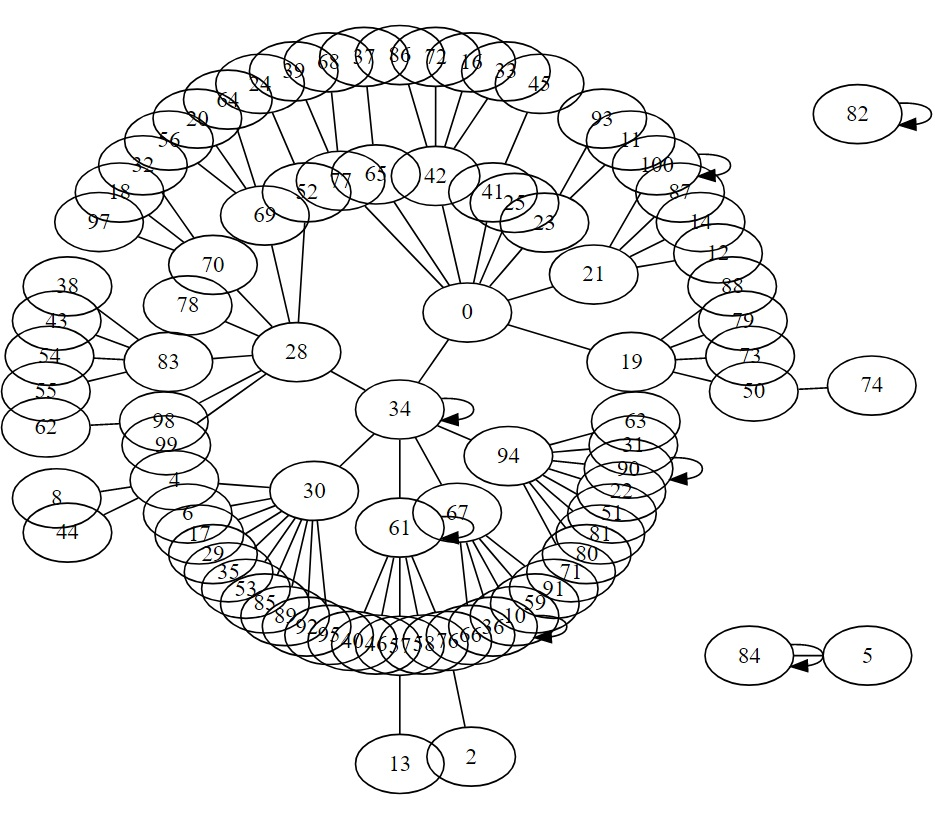

In [27]:
# https://dreampuf.github.io/GraphvizOnline/
# twopi visualisation
'''for x in tree: 
    print('"'+str(x[1])+'" -> "'+str(x[0])+'" [dir=none]')
    
for x,y in d_nodes.items():     
    try:
        if y > 0: 
            print('"'+str(x)+'" -> "'+str(x)+'"')
    except:
        print(y)'''

from IPython.display import Image

print()
Image('cut_a_graph_undirected.jpg')